# Segunda prueba de clustering, incluyendo duración media

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# interactivo, exportable:
%matplotlib notebook
# más rápido:
# %matplotlib inline

dataframes = (pd.read_csv("../data3/data.{}".format(day)) for day in ['18may','19may','20may','21may','22may','23may','24may'])
grouped_data = pd.concat(dataframes)
grouped_data.head()

,src_ip,dst_ip,proto,src_port,dst_port,anom_level,threat_level,max_prio,count_events,avg_duration,stdev_duration,active_hours_vector
0,172.24.80.14,91,1,4300,2,0.24,0.0,4,14533,8.54,76.64,184;179;98;146;188;199;200;216;234;205;192;207...
1,172.28.0.248,62,1,162,3,0.04,0.0,4,483,108.46,413.59,10;19;4;8;10;16;4;6;5;5;6;3;6;8;5;4;4;10;6;7;2...
2,172.28.15.47,45,1,9677,2,0.25,0.0,4,42912,5.27,3.01,6;12;3;3;6;651;801;797;751;790;779;704;730;691...
3,172.24.92.13,11,1,12,1,0.00,0.0,5,19,50.42,59.00,2;0;0;0;1;0;1;1;0;0;0;0;0;0;0;0;0;0;1;4;0;1;0;1
4,125.132.114.57,38,1,57,2,0.09,0.0,4,162,348.90,1480.32,5;1;3;1;6;2;2;1;1;0;3;2;1;1;1;7;4;1;3;2;4;3;1;3


## K-Means

In [2]:
from sklearn.cluster import KMeans

x_varnames = [['dst_port','dst_ip'], ['count_events','dst_ip'], ['max_prio','dst_ip'],
              ['avg_duration','dst_ip'],['avg_duration','count_events']]

x_vars = []
for n in x_varnames:
    x_vars.append(grouped_data[n].iloc[: , :].values)

### Selección de K por el método del codo

Por lo visto en la gráfica, se probarán:
- **k=2** y **k=3** para 'dst_port','dst_ip'
- **k=3** y **k=4** para 'count_events','dst_ip'
- **k=3** y **k=4** para 'avg_count','count_events'

<IPython.core.display.Javascript object>


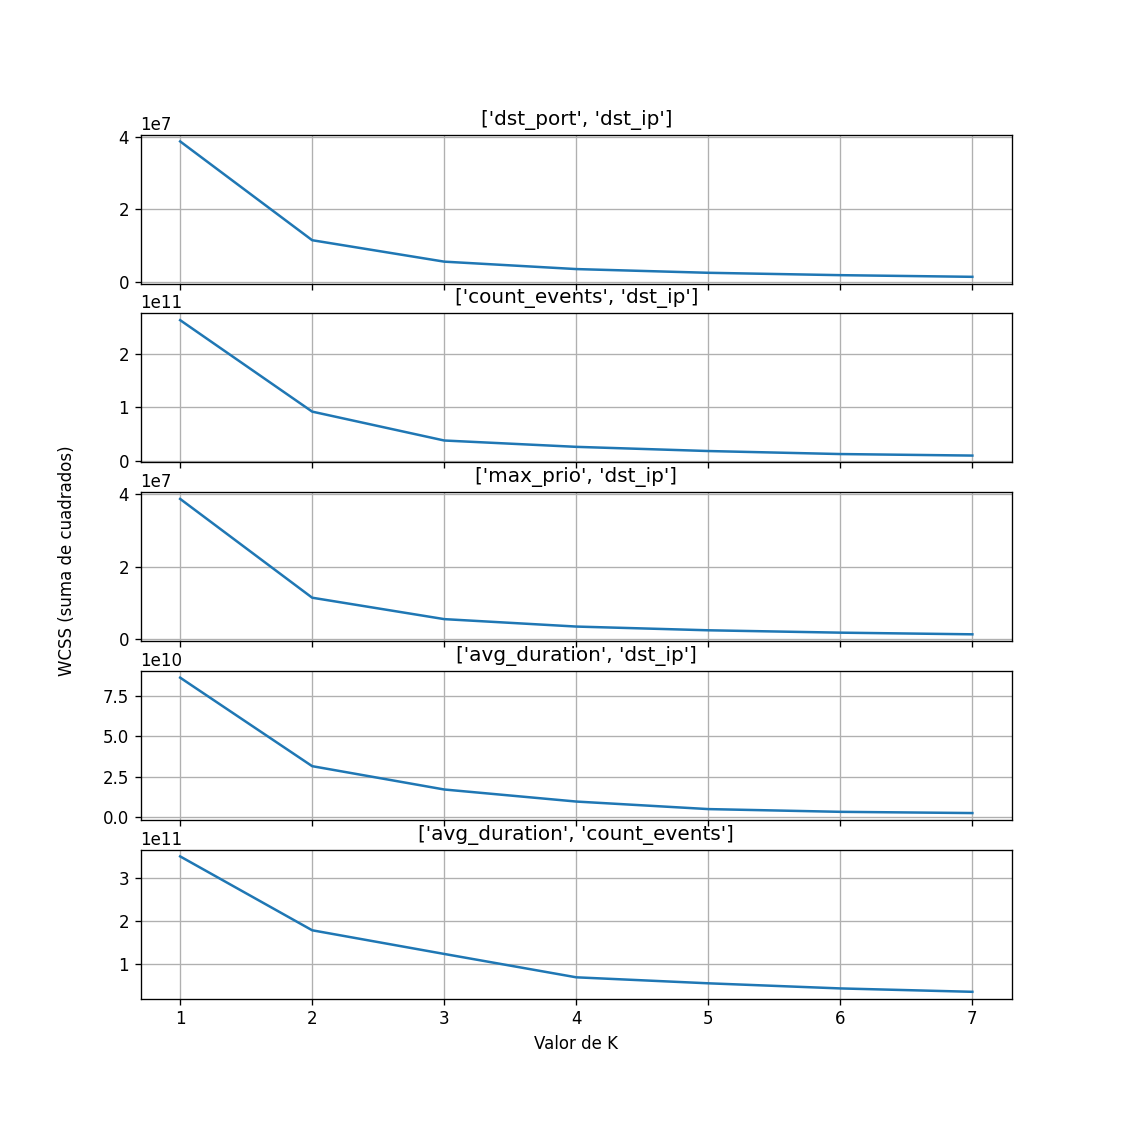

CPU times: user 25.9 s, sys: 47.3 s, total: 1min 13s
Wall time: 10.1 s


In [3]:
%%time

fig, axis = plt.subplots(len(x_vars), sharex=True)

for i,x in enumerate(x_vars):
    WCSS = []
    for k in range(1,8):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x)
        WCSS.append(kmeans.inertia_)

    axis[i].title.set_text(x_varnames[i])
    axis[i].plot(range(1,8),WCSS)
    axis[i].grid()

#plt.ylabel("WCSS (suma de cuadrados)") # suma de las distancias al cuadrado
                                        # entre cada miembro del cluster y su centroide
fig.text(0.06, 0.5, "WCSS (suma de cuadrados)", ha='center', va='center', rotation='vertical')
plt.xlabel("Valor de K")

plt.show()

In [ ]:
########
########
# =>> Parámetros a elegir <<=
###
###

In [4]:
# índice de los x_vars, para probar con una pareja cada vez:

#i = 0 # ['dst_port','dst_ip']
#i = 1 # ['count_events','dst_ip']
#i = 2 # ['max_prio','dst_ip']
i = 3 # ['avg_duration','dst_ip']
#i = 4 # ['avg_duration','count_events']

# valor de k con el que se está probando:

#k = 2
k = 3
#k = 4

In [ ]:
###
###
########
########

(Código adaptado de [https://www.kaggle.com/burakkahveci/unsupervised-learning-applications](https://www.kaggle.com/burakkahveci/unsupervised-learning-applications))

In [5]:
%%time

algo = KMeans(n_clusters = k) #,init='k-means++', n_init = 10 ,max_iter=300, 
#                        tol=0.0001,  random_state= 111  , algorithm='elkan')

clusters = algo.fit_predict(x_vars[i])
labels = algo.labels_
centroids = algo.cluster_centers_

CPU times: user 600 ms, sys: 1.08 s, total: 1.68 s
Wall time: 228 ms


In [6]:
%%time

h = 5 # resolution in the meshgrid. higher h -> lower MemAllocated
#h = 100 # <- i = 4 # when using 'count_events'
x_min, x_max = x_vars[i][:, 0].min() - 1, x_vars[i][:, 0].max() + 1
y_min, y_max = x_vars[i][:, 1].min() - 1, x_vars[i][:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algo.predict(np.c_[xx.ravel(), yy.ravel()])

CPU times: user 1.19 s, sys: 3.42 s, total: 4.61 s
Wall time: 1.14 s


<IPython.core.display.Javascript object>


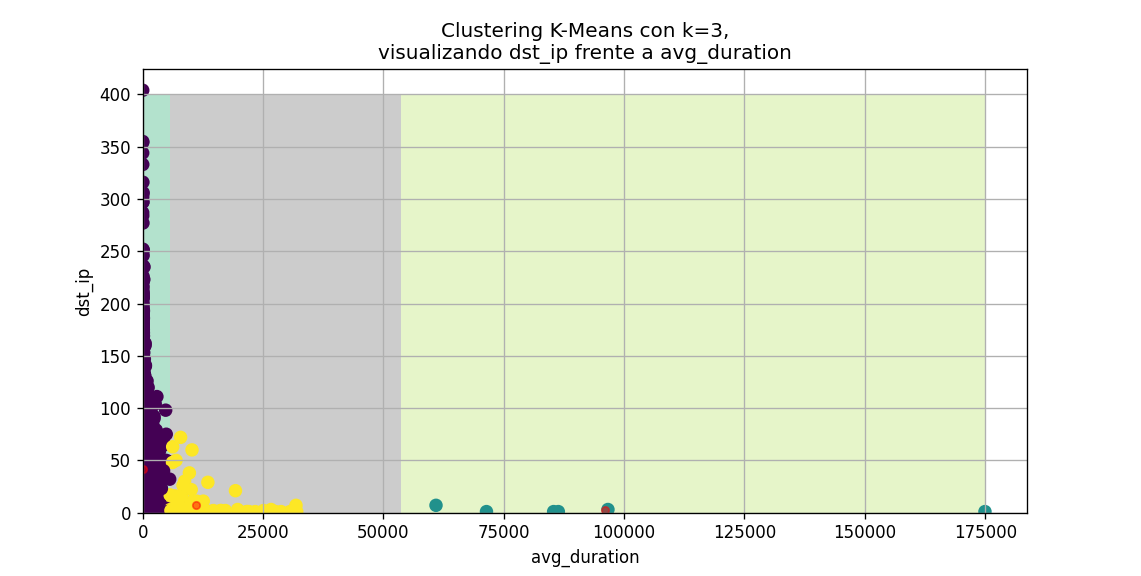

In [7]:
#%%time

Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = x_varnames[i][0], y = x_varnames[i][1], data = grouped_data, c = labels, s = 50 )
plt.scatter(x = centroids[: , 0] , y =  centroids[: , 1] , s = 20 , c = 'red' , alpha = 0.5)
plt.ylabel(f'{x_varnames[i][1]}') , plt.xlabel(f'{x_varnames[i][0]}')
plt.grid()
plt.title(f"Clustering K-Means con k={k},\nvisualizando {x_varnames[i][1]} frente a {x_varnames[i][0]}")
plt.show()

In [ ]:
# visualizando dst_ip frente a avg_duration, hay 6 sesiones con pocas conexiones muy largas:

'''
$ for f in data2/*; do awk -F"," '($(NF-1)>55000){print}' $f; done
data.18may: (red desarrollo) 10.253.15.157,1,1,1,1,0.00,0.00,5,189,85356.00,1589789438
data.19may: (colima.domcoin.net) 10.252.2.87,7,1,12,3,0.00,0.00,5,993,60928.08,1589967936;1589922382;1589976415;1589926393;1589894482;1589957897;1589910426;1589954049;1589945392;1589927115;1589212861;1589957176
data.19may: (vassan.domcoin.net, red dmz interna) 172.29.2.71,1,1,1,1,0.00,0.00,5,593,71409.00,1589872737
data.20may: (red domcoin) 10.252.0.174,1,1,1,1,0.00,0.00,5,154,86336.00,1589965376
data.22may: (paracaima.domcoin.net) 10.252.3.111,3,1,4,2,0.12,0.00,4,622,96641.50,1590236499;1589815907;1590170417;1590218528
data.24may: (red desarrollo) 10.253.15.157,1,1,1,1,0.00,0.00,5,1241,174946.00,1590218404
'''